# Streaming ERA5 data via DESP

In [33]:
import matplotlib.pyplot as plt
import xarray as xr
from oggm import (
    cfg,
    utils,
    workflow,
    
)
from dtcg.datacube import desp_era5
import seaborn as sns
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})
# plt.rcParams["image.cmap"] = "Set1"
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=plt.cm.Set1.colors)

In [2]:
cfg.initialize(logging_level="WARNING")
cfg.PATHS["working_dir"] = utils.gettempdir(dirname="OGGM-shop")
cfg.PARAMS["border"] = 80
cfg.PARAMS["store_model_geometry"] = True
cfg.PARAMS["use_multiprocessing"] = True
rgi_ids = ["RGI60-11.00897", "RGI60-11.00001"]
base_url = (
    "https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/"
    "L3-L5_files/2023.3/elev_bands/W5E5"
)
from_prepro_level = 4
prepro_border = 80
prepro_rgi_version = 62

def check_file_exists(gdirs: list, basename: str = "climate_historical"):
    for gdir in gdirs:
        assert basename in cfg.BASENAMES
        assert gdir.has_file(basename)

2025-09-29 14:54:23: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-09-29 14:54:23: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-09-29 14:54:23: oggm.cfg: Multiprocessing: using all available processors (N=22)
2025-09-29 14:54:24: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.
2025-09-29 14:54:24: oggm.cfg: Multiprocessing switched ON after user settings.


In [3]:
gdirs = workflow.init_glacier_directories(
    rgi_ids,
    from_prepro_level=from_prepro_level,
    prepro_base_url=base_url,
    prepro_rgi_version=prepro_rgi_version,
    prepro_border=prepro_border,
)
check_file_exists(gdirs=gdirs)

2025-09-29 14:54:24: oggm.workflow: init_glacier_directories from prepro level 4 on 2 glaciers.
2025-09-29 14:54:24: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 2 glaciers


Let's see how many years of ERA5 data are available through the OGGM cluster:

In [4]:
gdir= gdirs[0]
with xr.open_dataset(gdir.get_filepath("climate_historical")) as ds:
    ds = ds.load()
    print(f"Years of data: {ds.yr_0}-{ds.yr_1}")

Years of data: 1901-2019


sh: 1: getfattr: not found


We can stream data from DESP directly via DTCG:

In [6]:
gdir = gdirs[0]
desp_era5.process_desp_era5_data(
    gdir,
    settings_filesuffix="",
    dataset="ERA5_DESP",
    y0=2020,
    y1=2024,
    output_filesuffix=None,
)

with xr.open_dataset(gdir.get_filepath("climate_historical")) as ds:
    ds = ds.load()
    print(f"Years of data: {ds.yr_0}-{ds.yr_1}")

Years of data: 2020-2024


sh: 1: getfattr: not found


Or use OGGM's workflow functions:

In [7]:
ds_merged = workflow.execute_entity_task(
    gdirs=[gdirs[1]], task=desp_era5.process_desp_era5_data, y0=2020, y1=2024
)

2025-09-29 14:54:41: oggm.workflow: Execute entity tasks [process_desp_era5_data] on 1 glaciers


In [8]:
gdir= gdirs[1]
with xr.open_dataset(gdir.get_filepath("climate_historical")) as ds:
    ds = ds.load()
print(f"Years of data: {ds.yr_0}-{ds.yr_1}")

Years of data: 2020-2024


sh: 1: getfattr: not found


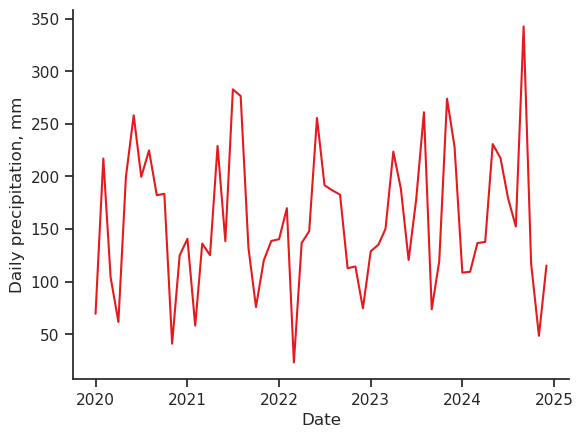

In [40]:
import matplotlib.pyplot as plt

fig = sns.lineplot(data=ds, x="time", y="prcp")
fig.set_ylabel("Daily precipitation, mm")
fig.set_xlabel("Date");

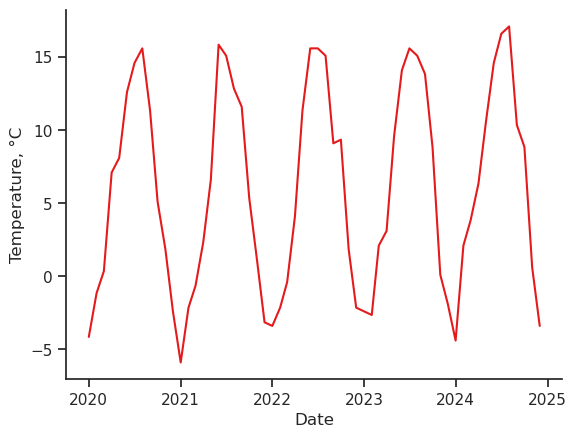

In [41]:
fig = sns.lineplot(data=ds, x="time", y="temp")
fig.set_ylabel("Temperature, °C")
fig.set_xlabel("Date");